In [125]:
import pandas as pd
from pandas import DataFrame
from pandas import concat

In [126]:
data = pd.read_csv("D:/MSCS/ML/Research_Work/parking_dataset/parksData.csv", index_col='LastUpdated')

In [127]:
data.head()

,SystemCodeNumber,Capacity,Occupancy,OccupancyRate,AvailabilityRate
LastUpdated,,,,,
10/4/2016 7:59,BHMBCCMKT01,577,61,0.894281,0.105719
10/4/2016 8:25,BHMBCCMKT01,577,64,0.889081,0.110919
10/4/2016 8:59,BHMBCCMKT01,577,80,0.861352,0.138648
10/4/2016 9:32,BHMBCCMKT01,577,107,0.814558,0.185442
10/4/2016 9:59,BHMBCCMKT01,577,150,0.740035,0.259965


In [128]:
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
data['SystemCodeNumber'] = number.fit_transform(data['SystemCodeNumber'].astype('str'))

In [129]:
data.head()

,SystemCodeNumber,Capacity,Occupancy,OccupancyRate,AvailabilityRate
LastUpdated,,,,,
10/4/2016 7:59,0,577,61,0.894281,0.105719
10/4/2016 8:25,0,577,64,0.889081,0.110919
10/4/2016 8:59,0,577,80,0.861352,0.138648
10/4/2016 9:32,0,577,107,0.814558,0.185442
10/4/2016 9:59,0,577,150,0.740035,0.259965


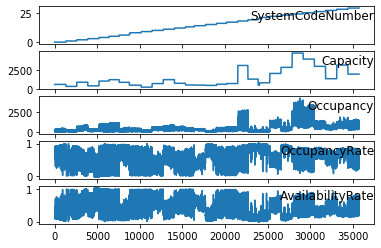

In [130]:
from matplotlib import pyplot
# load dataset
values = data.values
# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(data.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [131]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [132]:
values = data.values

In [133]:
from sklearn.preprocessing import MinMaxScaler

In [134]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7,8]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var5(t)
1        0.0   0.080135   0.015917   0.884324   0.115676  0.120590
2        0.0   0.080135   0.016609   0.879410   0.120590  0.146799
3        0.0   0.080135   0.020300   0.853201   0.146799  0.191027
4        0.0   0.080135   0.026528   0.808973   0.191027  0.261464
5        0.0   0.080135   0.036448   0.738536   0.261464  0.305692


In [135]:
# split into train and test sets
values = reframed.values
n_train_hours = 1000 * 25
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(25000, 1, 5) (25000,) (10716, 1, 5) (10716,)


In [136]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


In [149]:
# design network
model = Sequential()
model.add(LSTM(64,activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu',return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 25000 samples, validate on 10716 samples
Epoch 1/100
 - 4s - loss: 0.2009 - val_loss: 0.0842
Epoch 2/100
 - 2s - loss: 0.1189 - val_loss: 0.0409
Epoch 3/100
 - 2s - loss: 0.1075 - val_loss: 0.0450
Epoch 4/100
 - 2s - loss: 0.0984 - val_loss: 0.0435
Epoch 5/100
 - 2s - loss: 0.0931 - val_loss: 0.0490
Epoch 6/100
 - 2s - loss: 0.0894 - val_loss: 0.0485
Epoch 7/100
 - 2s - loss: 0.0874 - val_loss: 0.0505
Epoch 8/100
 - 2s - loss: 0.0865 - val_loss: 0.0529
Epoch 9/100
 - 2s - loss: 0.0851 - val_loss: 0.0489
Epoch 10/100
 - 2s - loss: 0.0855 - val_loss: 0.0481
Epoch 11/100
 - 2s - loss: 0.0847 - val_loss: 0.0525
Epoch 12/100
 - 2s - loss: 0.0840 - val_loss: 0.0497
Epoch 13/100
 - 2s - loss: 0.0839 - val_loss: 0.0494
Epoch 14/100
 - 2s - loss: 0.0842 - val_loss: 0.0527
Epoch 15/100
 - 2s - loss: 0.0831 - val_loss: 0.0546
Epoch 16/100
 - 2s - loss: 0.0827 - val_loss: 0.0509
Epoch 17/100
 - 2s - loss: 0.0824 - val_loss: 0.0499
Epoch 18/100
 - 2s - loss: 0.0831 - val_loss: 0.0551
Epoch

In [138]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 1, 128)            68608     
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 1, 64)             49408     
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)               

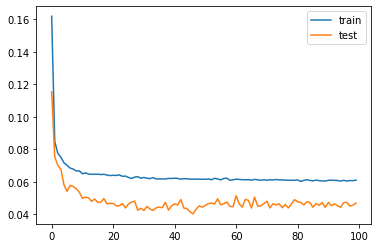

In [139]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [140]:
from math import sqrt


In [141]:
# make a prediction
yhat = model.predict(test_X)
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.069


In [142]:
from sklearn.metrics import median_absolute_error,mean_absolute_error,mean_squared_error,mean_squared_log_error

In [143]:
mean_absolute_error(test_y, yhat)

0.04681279

In [144]:
mean_squared_error(test_y, yhat)

0.004826914

In [145]:
median_absolute_error(test_y, yhat)

0.03587836

In [146]:
mean_squared_log_error(test_y, yhat)

0.002546247